In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (InputLayer, Conv2D, MaxPool2D, 
                                     Flatten, Dense, Conv2DTranspose, 
                                     UpSampling2D, Reshape)
from tensorflow.keras.losses import mse

# x.summary()
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
pics = np.load('play_trace_0.npz')

In [9]:
IMG_HEIGHT = 64 
IMG_WIDTH = 64

In [18]:
class CVAE(tf.keras.Model):
    
    def __init__(self, latent_dim=64, activation='relu', initializer='he_normal', 
                 optimizer=tf.keras.optimizers.Adam(1e-4), 
                 reconstruction_lossfun=mse, fname=None):
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.optimizer = optimizer
        self.reconstruction_lossfun = reconstruction_lossfun
        self.inference_net = tf.keras.Sequential(
          [
              InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
              Conv2D(filters=16, kernel_size=3, strides=2, 
                     activation=activation, kernel_initializer=initializer),
              #BatchNormalization(),
              Conv2D(filters=32, kernel_size=3, strides=2,
                     activation=activation, kernel_initializer=initializer),
              #BatchNormalization(),
              Conv2D(filters=64, kernel_size=3, strides=2,
                     activation=activation, kernel_initializer=initializer),
              #BatchNormalization(),
              MaxPool2D(),
              Flatten(),
              Dense(self.latent_dim + self.latent_dim) 
          ]
        )

        self.generative_net = tf.keras.Sequential(
            [
                InputLayer(input_shape=(self.latent_dim,)),
                Dense(64, activation=activation),
                Reshape((4,4,4)),
                Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',
                                activation=activation, kernel_initializer=initializer),
                UpSampling2D(),
                Conv2D(filters=64, kernel_size=1, strides=1),
                UpSampling2D(),
                Conv2D(filters=64, kernel_size=1, strides=1),
                Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',
                                activation=activation, kernel_initializer=initializer),
                Conv2DTranspose(filters=3, kernel_size=1, strides=1)
            ]
        )
        
        if fname: 
            self.load_weights(fname)
        return
    
    def sample(self, n=10, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(n, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def encode_to_z(self, x):
        mean, logvar = self.encode(x)
        return self.reparameterize(mean, logvar)
    
    def predict(self, x):
        z = self.encode_to_z(x)
        return self.decode(z, apply_sigmoid=True)
    
    @staticmethod
    def log_normal_pdf(sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
                          axis=raxis)
    
    def summary(self): 
        print('Encoder summary:')
        self.inference_net.summary()
        print('Decoder summary:')
        self.generative_net.summary()
        return
    
    def compute_loss(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        pred = self.decode(z, apply_sigmoid=True)
        reconstruction_loss = self.reconstruction_lossfun(pred, x)
        reconstruction_loss = tf.reduce_mean(reconstruction_loss, 2)
        reconstruction_loss = tf.reduce_mean(reconstruction_loss, 1)
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        #import pdb; pdb.set_trace()
        return -tf.reduce_mean(reconstruction_loss + logpz - logqz_x)

    def compute_apply_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
            gradients = tape.gradient(loss, self.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss
            
    def save_weights(self, name): 
        self.inference_net.save_weights(f'{name}_inference.hdf5')
        self.generative_net.save_weights(f'{name}_generative.hdf5')
        return
    
    def load_weights(self, name):
        self.inference_net.load_weights(f'{name}_inference.hdf5')
        self.generative_net.load_weights(f'{name}_generative.hdf5')
        return
    
    def fit(self, train_generator, test_generator, fname, epochs=100, val_frequency=1):
        """Note: this breaks the usual model.fit API"""
        
        history = {'loss': [], 'val_loss': []}
        for epoch in range(1, epochs + 1):
            start_time = time.time()
            loss = tf.keras.metrics.Mean()
            for train_x in tqdm(train_generator, f"epoch: {epoch}"):
                loss(self.compute_apply_gradients(train_x))
            end_time = time.time()
            elbo = -loss.result()
            history['loss'].append(np.asscalar(np.array(elbo)))
            
            if epoch % val_frequency == 0:
                loss = tf.keras.metrics.Mean()
                for test_x in tqdm(test_generator, f"validating epoch {epoch}"):
                    loss(self.compute_loss(test_x))
                elbo = -loss.result()
                history['val_loss'].append(np.asscalar(np.array(elbo)))
                print('Epoch: {}, Test set ELBO: {}, '
                      'time elapse for current epoch {}'.format(epoch,
                                                                elbo,
                                                                end_time - start_time))
        self.save_weights(fname)
        return history

In [19]:
x = CVAE()

In [65]:
o = x.predict(resize(pics['b']/255, (1024, 64, 64, 3)))

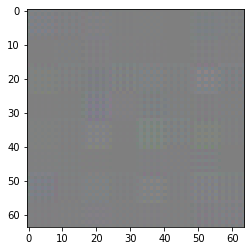

In [67]:
plt.imshow(o[0])

In [69]:
import mdn

In [70]:
N_HIDDEN = 15  # number of hidden units in the Dense layer
N_MIXES = 10  # number of mixture components
OUTPUT_DIMS = 2  # number of real-values predicted by each mixture component

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=tf.keras.optimizers.Adam())
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 15)                30        
_________________________________________________________________
mdn (MDN)                    (None, 50)                800       
Total params: 830
Trainable params: 830
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class MDN_RNN:
    def __init__(self):
        pass

In [1]:
class controller:
    def __init__(self):
        pass